In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
!pip install dagshub mlflow --quiet
!pip install imbalanced-learn==0.11.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 47.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.0/700.0 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [3]:

import dagshub
import mlflow

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
import xgboost as xgb
from category_encoders import WOEEncoder
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline  # ✅ Corrected import
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
import mlflow.data
from mlflow.data.pandas_dataset import PandasDataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [4]:
import mlflow
from dagshub import dagshub_logger
import os

# Set tracking URI manually
mlflow.set_tracking_uri("https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow")

# Use your DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "nkikn21"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "90ec7031365aea1b6ca271f4236c194e530973c8"

# Optional: set registry if you're using model registry
mlflow.set_registry_uri("https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow")



In [5]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [6]:
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
# test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
# test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

In [7]:
# test_identity.columns = test_identity.columns.str.replace('-', '_')

# print("Updated Test Columns:", test_identity.columns)

In [7]:
train_joined = train_transaction.merge(train_identity, on="TransactionID", how="left")
# test_joined = test_transaction.merge(test_identity, on="TransactionID", how="left")

In [8]:
train_joined['TransactionDay'] = train_joined['TransactionDT'] // (24*60*60)
# test_joined['TransactionDay'] = test_joined['TransactionDT'] // (24*60*60)
cutoff_day = train_joined['TransactionDay'].max() - 30  # last 30 days for validation

train_data = train_joined[train_joined['TransactionDay'] <= cutoff_day]
val_data = train_joined[train_joined['TransactionDay'] > cutoff_day]

X_train = train_data.drop(columns=['isFraud', 'TransactionID'])
y_train = train_data['isFraud']

X_val = val_data.drop(columns=['isFraud', 'TransactionID'])
y_val = val_data['isFraud']

# X_test = test_joined.drop(columns=['TransactionID', 'isFraud'], errors='ignore')  # Ignore errors in case 'isFraud' isn't in test_joined


In [9]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [10]:
s = X_train[cat_cols].nunique()

threshold = 3

woe_columns = list(s[s > threshold].index)
one_hot_columns = list(s[s <= threshold].index)

# Cleaning

In [36]:
# import mlflow
# from sklearn.base import BaseEstimator, TransformerMixin

# class Cleaning(BaseEstimator, TransformerMixin):
    
#     def __init__(self, woe_columns, one_hot_columns, num_cols, log_mlflow=False):
#         self.woe_columns = woe_columns
#         self.one_hot_columns = one_hot_columns
#         self.num_cols = num_cols
#         self.log_mlflow = log_mlflow

#     def fit(self, X, y=None):
#         # Save mode for categorical columns and median for numerical columns
#         self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()  # mode
#         self.one_hot_columns_fill_na = X[self.one_hot_columns].mode().T[0].to_dict()  # mode
#         self.num_cols_fill_na = X[self.num_cols].median().to_dict()  # median
#         if self.log_mlflow:
#             experiment_name = 'XGBoost_Training'
#             run_name = 'XGBoost_Cleaning'
            
#             mlflow.set_experiment(experiment_name)
#             mlflow.start_run(run_name=run_name)

#             mlflow.log_param("cat_cols_handling", "mode")
#             mlflow.log_param("num_cols_handling", "median")
    
#             mlflow.end_run()
        
#         return self

#     def transform(self, X):
#         X_transformed = X.copy()

#         # Fill missing values for WOE columns (categorical)
#         for col in self.woe_columns:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.woe_columns_fill_na[col])

#         # Fill missing values for One-Hot columns (categorical)
#         for col in self.one_hot_columns:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.one_hot_columns_fill_na[col])

#         # Fill missing values for num_cols (continuous)
#         for col in self.num_cols:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.num_cols_fill_na[col])

#         return X_transformed



In [42]:
# import mlflow
# from sklearn.base import BaseEstimator, TransformerMixin

# class Cleaning(BaseEstimator, TransformerMixin):
    
#     def __init__(self, woe_columns, one_hot_columns, num_cols, log_mlflow=False, null_threshold=0.8):
#         self.woe_columns = woe_columns
#         self.one_hot_columns = one_hot_columns
#         self.num_cols = num_cols
#         self.log_mlflow = log_mlflow
#         self.null_threshold = null_threshold

#     def fit(self, X, y=None):
#         # Drop columns with more than threshold% missing values
#         null_frac = X.isnull().mean()
#         self.to_drop = null_frac[null_frac > self.null_threshold].index.tolist()

#         # Fill strategies for remaining columns
#         self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
#         self.one_hot_columns_fill_na = X[self.one_hot_columns].mode().T[0].to_dict()
#         self.num_cols_fill_na = X[self.num_cols].median().to_dict()

#         # MLflow logging
#         if self.log_mlflow:
#             experiment_name = 'XGBoost_Training'
#             run_name = 'XGBoost_Cleaning'
            
#             mlflow.set_experiment(experiment_name)
#             mlflow.start_run(run_name=run_name)

#             mlflow.log_param("cat_cols_handling", "mode")
#             mlflow.log_param("num_cols_handling", "median")
#             mlflow.log_param("dropped_cols_threshold", self.null_threshold)
#             mlflow.log_param("dropped_columns", self.to_drop)

#             mlflow.end_run()
        
#         return self

#     def transform(self, X):
#         X_transformed = X.copy()

#         # Drop columns identified during fit
#         X_transformed = X_transformed.drop(columns=self.to_drop, errors='ignore')

#         # Fill WOE columns
#         for col in self.woe_columns:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.woe_columns_fill_na.get(col))

#         # Fill one-hot columns
#         for col in self.one_hot_columns:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.one_hot_columns_fill_na.get(col))

#         # Fill numeric columns
#         for col in self.num_cols:
#             if col in X_transformed.columns:
#                 X_transformed[col] = X_transformed[col].fillna(self.num_cols_fill_na.get(col))

#         return X_transformed


In [11]:
import mlflow
from sklearn.base import BaseEstimator, TransformerMixin

class Cleaning(BaseEstimator, TransformerMixin):

    def __init__(self, woe_columns, one_hot_columns, num_cols, log_mlflow=False, null_threshold=0.8):
        self.woe_columns = woe_columns
        self.one_hot_columns = one_hot_columns
        self.num_cols = num_cols
        self.log_mlflow = log_mlflow
        self.null_threshold = null_threshold

        # Initialize all attributes needed in transform()
        self.to_drop = []
        self.woe_columns_fill_na = {}
        self.one_hot_columns_fill_na = {}
        self.num_cols_fill_na = {}

    def fit(self, X, y=None):
        # Drop columns with more than threshold% missing values
        null_frac = X.isnull().mean()
        self.to_drop = null_frac[null_frac > self.null_threshold].index.tolist()

        # Fill strategies
        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
        self.one_hot_columns_fill_na = X[self.one_hot_columns].mode().T[0].to_dict()
        self.num_cols_fill_na = X[self.num_cols].median().to_dict()

        # MLflow logging
        if self.log_mlflow:
            experiment_name = 'XGBoost_Training'
            run_name = 'XGBoost_Cleaning'
            
            mlflow.set_experiment(experiment_name)
            with mlflow.start_run(run_name=run_name):
                mlflow.log_param("cat_cols_handling", "mode")
                mlflow.log_param("num_cols_handling", "median")
                mlflow.log_param("dropped_cols_threshold", self.null_threshold)
                mlflow.log_param("dropped_columns", self.to_drop)

        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Drop columns
        X_transformed = X_transformed.drop(columns=self.to_drop, errors='ignore')

        # Fill WOE columns
        for col in self.woe_columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].fillna(self.woe_columns_fill_na.get(col))

        # Fill one-hot columns
        for col in self.one_hot_columns:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].fillna(self.one_hot_columns_fill_na.get(col))

        # Fill numeric columns
        for col in self.num_cols:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].fillna(self.num_cols_fill_na.get(col))

        return X_transformed


# Feature Engineering

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import mlflow

class FeatureEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self, woe_columns=None, one_hot_columns=None, woe_mappings=None, woe_columns_fill_na=None, log_mlflow=False):
        self.woe_columns = woe_columns
        self.one_hot_columns = one_hot_columns
        self.woe_mappings = woe_mappings
        self.woe_columns_fill_na = woe_columns_fill_na
        self.log_mlflow = log_mlflow

    def fit(self, X, y=None):
        # Assign default dicts if None (safe to do here)
        self.woe_mappings_ = self.woe_mappings or {}
        self.woe_columns_fill_na_ = self.woe_columns_fill_na or {}

        # Optional: make sure columns exist
        self.woe_columns_ = [col for col in self.woe_columns if col in X.columns]
        self.one_hot_columns_ = [col for col in self.one_hot_columns if col in X.columns]

        # Log to MLflow
        if self.log_mlflow:
            experiment_name = "XGBoost_Training"
            run_name = "XGBoost_Feature_Engineering"
            mlflow.set_experiment(experiment_name)
            with mlflow.start_run(run_name=run_name):
                mlflow.log_param("woe_columns", self.woe_columns_)
                mlflow.log_param("one_hot_columns", self.one_hot_columns_)

        return self

    def transform(self, X):
        X_transformed = X.copy()

        # WOE encoding
        for col in self.woe_columns_:
            mapping = self.woe_mappings_.get(col, {})
            default_val = mapping.get(self.woe_columns_fill_na_.get(col), 0)
            new_col = f'{col}_woe'
            X_transformed[new_col] = X_transformed[col].map(mapping).fillna(default_val)
            X_transformed.drop(columns=col, inplace=True)

        # One-hot encoding
        X_transformed = pd.get_dummies(
            X_transformed, 
            columns=self.one_hot_columns_, 
            drop_first=True, 
            dummy_na=True,
            dtype=int
        )

        return X_transformed


# Feature Selection

In [13]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, model, correlation_threshold=0.8, n_features_to_select=20, log_mlflow=False):
        self.model = model
        self.correlation_threshold = correlation_threshold
        self.n_features_to_select = n_features_to_select
        self.log_mlflow = log_mlflow

    def fit(self, X, y=None):
        # Step 1: Remove highly correlated features
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop = [column for column in upper.columns if any(upper[column] > self.correlation_threshold)]
    
        # Step 2: Run RFE to select top N features
        self.rfe = RFE(self.model, n_features_to_select=self.n_features_to_select)
        self.rfe.fit(X, y)
    
        all_rfe_features = X.columns[self.rfe.support_].tolist()
    
        # Step 3: Final selected features = RFE features minus highly correlated
        self.selected_features = [col for col in all_rfe_features if col not in self.to_drop]
    
        # Step 4: Log to MLflow if enabled
        if self.log_mlflow:
            experiment_name = 'XGBoost_Training'
            run_name = 'XGBoost_Feature_Selection'
            
            mlflow.set_experiment(experiment_name)
            mlflow.start_run(run_name=run_name)
            
            mlflow.log_param("RFE_all_features", all_rfe_features)
            mlflow.log_param("Highly_correlated_dropped", self.to_drop)
            mlflow.log_param("Selected_features", self.selected_features)

            mlflow.end_run()
    
        return self


    def transform(self, X):
        return X[self.selected_features]


# Training

In [14]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# Create the pipeline with XGBoost instead of LogisticRegression
imb_pipeline = ImbPipeline(steps=[
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.4)),
    
    ('cleaning', Cleaning(woe_columns=woe_columns, 
                                             one_hot_columns=one_hot_columns, 
                                             num_cols=num_cols, log_mlflow=True)),
    
    ('feature_engineering', FeatureEngineering(woe_columns=woe_columns, 
                                               one_hot_columns=one_hot_columns, log_mlflow=True)),
    
    ('feature_selection', FeatureSelection(model=XGBClassifier(
                                                use_label_encoder=False,
                                                enable_categorical=True,
                                                eval_metric='logloss', 
                                                random_state=42,
                                                tree_method = 'hist'
                                            ), n_features_to_select=20, log_mlflow=True)),
        
    ('scaler', StandardScaler()),
    
    ('classifier', XGBClassifier(
        use_label_encoder=False, 
        enable_categorical=True,
        eval_metric='logloss',
        random_state=42,
        tree_method = 'hist'
    ))
])

# mlflow.end_run()


**Model_v1**

In [15]:
imb_pipeline.fit(X_train, y_train)

🏃 View run XGBoost_Cleaning at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/8aae3ea5598347b4a87e65041985d4e2
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2
🏃 View run XGBoost_Feature_Engineering at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/aeb43439e72a44869d6856a0e65f1331
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


invalid value encountered in greater


🏃 View run XGBoost_Feature_Selection at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/f03f55d2acde4bfbae5babb536fa7ce8
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.4)),
                ('cleaning',
                 Cleaning(log_mlflow=True,
                          num_cols=['TransactionDT', 'TransactionAmt', 'card1',
                                    'card2', 'card3', 'card5', 'addr1', 'addr2',
                                    'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4',
                                    'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
                                    'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
                                    'D5', 'D6', ...],
                          one_h...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# experiment_name = 'XGBoost_Training'
# run_name = 'Model_v1'

# mlflow.set_experiment(experiment_name)
# mlflow.start_run(run_name=run_name)

# mlflow.sklearn.log_model(imb_pipeline, "XGB_pipeline")

# # Train the model
# # imb_pipeline.fit(X_train, y_train)

# # Log metrics (e.g., AUC, F1-score, etc.)
# y_pred = imb_pipeline.predict(X_val)
# y_pred_proba = imb_pipeline.predict_proba(X_val)[:, 1]

# auc_score = roc_auc_score(y_val, y_pred_proba)
# f1_score_val = f1_score(y_val, y_pred)
# precision_score_val = precision_score(y_val, y_pred)
# recall_score_val = recall_score(y_val, y_pred)

# mlflow.log_metric("AUC", auc_score)
# mlflow.log_metric("F1_Score", f1_score_val)
# mlflow.log_metric("Precision", precision_score_val)
# mlflow.log_metric("Recall", recall_score_val)

# # Log model parameters
# mlflow.log_param("RandomUnderSampler_Sampling_Strategy", 0.5)
# mlflow.log_param("Classifier", "XGBClassifier")

# # Optionally log additional parameters related to the model (e.g., hyperparameters for LogisticRegression)
# mlflow.log_param("n_estimators", 100)
# mlflow.log_param("max_depth", 2)
# mlflow.log_param("learning_rate", 0.1)
# mlflow.log_param("tree_method", "hist")

# mlflow.end_run()

**Model_v2**

In [16]:
# pip install optuna xgboost scikit-learn mlflow


Note: you may need to restart the kernel to use updated packages.


In [29]:
# import optuna
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# # Define the objective function for Optuna
# def objective(trial):
#     # Define hyperparameters to tune
#     param = {
#         'tree_method': 'hist',  # Histogram method for faster training
#         'use_label_encoder': False,
#         'n_estimators': 100,  # n_estimators to be tuned
#         'max_depth': trial.suggest_int('max_depth', 3, 5),  # max_depth to be tuned
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),  # learning_rate to be tuned
#         'random_state': 42,
#     }
    
#     # Initialize the model with hyperparameters from Optuna
#     model = xgb.XGBClassifier(**param)
    
#     # Train the model with early stopping
#     model.fit(
#         X_train, y_train, 
#         eval_set=[(X_val, y_val)], 
#         early_stopping_rounds=50, 
#         verbose=False
#     )
    
#     # Get the best score and return it
#     y_pred = model.predict_proba(X_val)[:, 1]
#     score = roc_auc_score(y_val, y_pred)
    
#     return score  # Maximize AUC

# # Create an Optuna study to maximize the AUC score
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, n_jobs=-1)  # You can adjust n_trials based on available resources

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Train the final model with the best parameters
# best_model = xgb.XGBClassifier(
#     **study.best_params
# )
# best_model.fit(X_train, y_train)


[I 2025-04-29 15:50:34,631] A new study created in memory with name: no-name-bce721a4-50fd-4c92-8f6f-72918186cb31
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[W 2025-04-29 15:50:34,659] Trial 0 failed with parameters: {'max_depth': 3, 'learning_rate': 0.27650134839801827} because of the following error: ValueError('DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ProductCD: ob

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ProductCD: object, card4: object, card6: object, P_emaildomain: object, R_emaildomain: object, M1: object, M2: object, M3: object, M4: object, M5: object, M6: object, M7: object, M8: object, M9: object, id_12: object, id_15: object, id_16: object, id_23: object, id_27: object, id_28: object, id_29: object, id_30: object, id_31: object, id_33: object, id_34: object, id_35: object, id_36: object, id_37: object, id_38: object, DeviceType: object, DeviceInfo: object

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grid — use "classifier__" prefix for XGBoost inside pipeline
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [2, 3, 5],
#     'classifier__learning_rate': [0.01, 0.1],
# }

# grid_search = GridSearchCV(
#     estimator=imb_pipeline,
#     param_grid=param_grid,
#     cv=3,  # or StratifiedKFold etc.
#     scoring='roc_auc',  # or your metric
#     n_jobs=-1,
#     verbose=2
# )

# # Run it (this might take time depending on param_grid size)
# grid_search.fit(X_train, y_train)

# # Access best results
# print("Best params:", grid_search.best_params_)
# print("Best AUC:", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [ ]:
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

In [41]:
# experiment_name = 'XGBoost_Training'
# run_name = 'Model_v2'

# mlflow.set_experiment(experiment_name)
# mlflow.start_run(run_name=run_name)

# mlflow.sklearn.log_model(imb_pipeline, "XGB_pipeline")

# # Train the model
# # imb_pipeline.fit(X_train, y_train)

# # Log metrics (e.g., AUC, F1-score, etc.)
# y_pred = imb_pipeline.predict(X_val)
# y_pred_proba = imb_pipeline.predict_proba(X_val)[:, 1]

# auc_score = roc_auc_score(y_val, y_pred_proba)
# f1_score_val = f1_score(y_val, y_pred)
# precision_score_val = precision_score(y_val, y_pred)
# recall_score_val = recall_score(y_val, y_pred)

# mlflow.log_metric("AUC", auc_score)
# mlflow.log_metric("F1_Score", f1_score_val)
# mlflow.log_metric("Precision", precision_score_val)
# mlflow.log_metric("Recall", recall_score_val)

# # Log model parameters
# mlflow.log_param("RandomUnderSampler_Sampling_Strategy", 0.5)
# mlflow.log_param("Classifier", "XGBClassifier")

# # Optionally log additional parameters related to the model (e.g., hyperparameters for LogisticRegression)
# mlflow.log_param("n_estimators", 100)
# mlflow.log_param("max_depth", 2)
# mlflow.log_param("learning_rate", 0.1)
# mlflow.log_param("tree_method", "hist")

# mlflow.end_run()

2025/04/29 17:45:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Model_v2 at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/da0f91b5e46649dc8ea1d5e28b590e92
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


**Model_v3**

In [49]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Convert object columns to category
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')  # if you plan to evaluate on val


# Example: Define model
xgb = XGBClassifier(
    eval_metric='auc',
    error_score='raise',
    enable_categorical=True,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Define parameter distribution
param_dist = {
    'n_estimators': np.random.randint(100, 501, size=10),  # 100 random ints between 100 and 500
    'max_depth': np.random.randint(3, 12, size=10),         # random ints from 3 to 11
    'learning_rate': np.random.uniform(0.01, 0.3, size=10), # float values between 0.01 and 0.3
}


# Randomized search CV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # Number of random combinations to try
    scoring='roc_auc',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search on training data
random_search.fit(X_train, y_train)

# Best model and score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score (CV):", random_search.best_score_)

# Optional: Evaluate on test set
best_model = random_search.best_estimator_

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:43:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "error_score" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:43:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "error_score" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:43:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "error_score" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:43:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "error_score" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:45:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "error_score" } are not used.

  war

Best Parameters: {'n_estimators': 424, 'max_depth': 3, 'learning_rate': 0.07786809364922012}
Best ROC AUC Score (CV): 0.8645464057959751


In [19]:
experiment_name = 'XGBoost_Training'
run_name = 'Model_v4'

mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

# mlflow.log_metric("n_estimators", auc_score)
# mlflow.log_metric("max_depth", f1_score_val)
# mlflow.log_metric("learning_rate", precision_score_val)

mlflow.sklearn.log_model(imb_pipeline, "XGB_pipeline")

# Train the model
# imb_pipeline.fit(X_train, y_train)

# Log metrics (e.g., AUC, F1-score, etc.)
y_pred = imb_pipeline.predict(X_val)
y_pred_proba = imb_pipeline.predict_proba(X_val)[:, 1]

auc_score = roc_auc_score(y_val, y_pred_proba)
f1_score_val = f1_score(y_val, y_pred)
precision_score_val = precision_score(y_val, y_pred)
recall_score_val = recall_score(y_val, y_pred)

mlflow.log_metric("AUC", auc_score)
mlflow.log_metric("F1_Score", f1_score_val)
mlflow.log_metric("Precision", precision_score_val)
mlflow.log_metric("Recall", recall_score_val)

# Log model parameters
mlflow.log_param("RandomUnderSampler_Sampling_Strategy", 0.4)
mlflow.log_param("Classifier", "XGBClassifier")

mlflow.end_run()

2025/04/30 20:22:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Model_v4 at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/3c97758d9a6c4869b3c466f3aa0db78a
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


**Feature Importances**

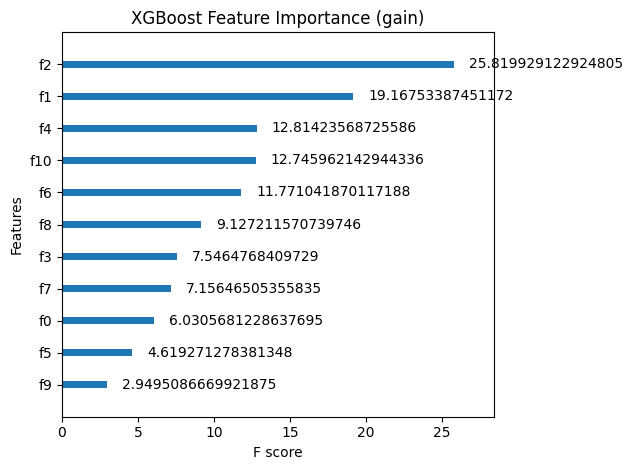

In [39]:
# Fit the pipeline
# imb_pipeline.fit(X_train, y_train)

# Extract the trained classifier
xgb_model = imb_pipeline.named_steps['classifier']

# Plot importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, importance_type='gain', max_num_features=40,
                title='XGBoost Feature Importance (gain)', grid=False)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Get feature importances from trained model
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['gain']).reset_index()
importance_df.columns = ['feature', 'gain']

# Sort and get top 10
top_gain_features = importance_df.sort_values(by='gain', ascending=False).head(10)
print(top_gain_features)


**SHAP**

100%|===================| 85394/85430 [04:03<00:00]        

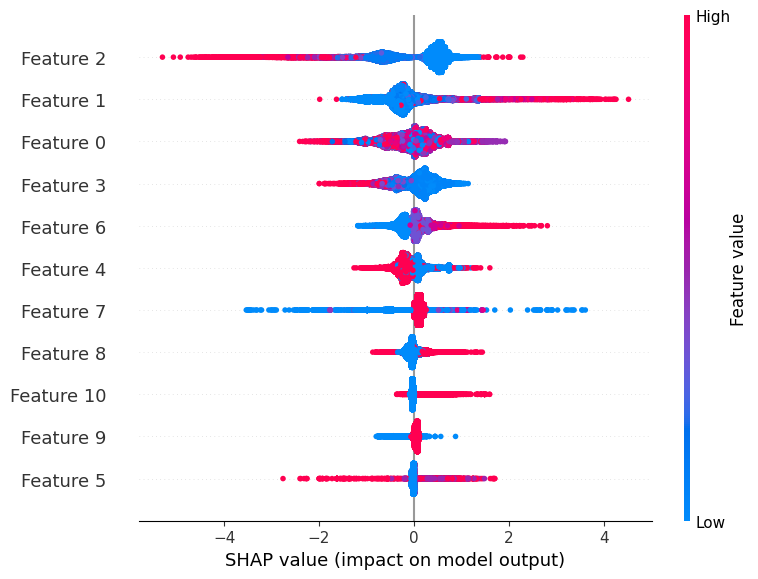

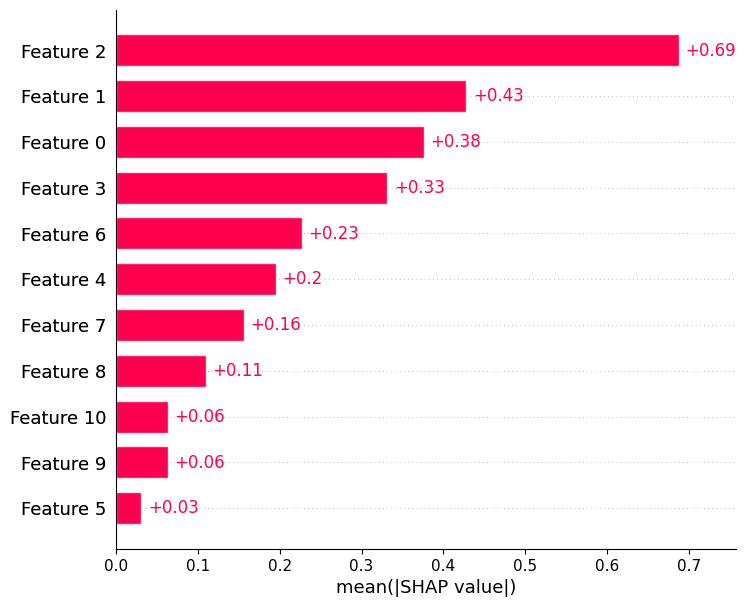

In [40]:
# 1. Fit the pipeline
# imb_pipeline.fit(X_train, y_train)

# 2. Extract preprocessing part (everything except classifier)
preprocessor = imb_pipeline[:-1]  # slice all steps except 'classifier'

# 3. Transform validation set
X_val_transformed = preprocessor.transform(X_val)

# 4. Extract the trained XGBoost model
xgb_model = imb_pipeline.named_steps['classifier']

# 5. Use SHAP with the trained model and transformed data
import shap

explainer = shap.Explainer(xgb_model, X_val_transformed)
shap_values = explainer(X_val_transformed)

# 6. Plot SHAP summary
shap.summary_plot(shap_values, X_val_transformed, max_display=20)

# 7. Plot SHAP bar
shap.plots.bar(shap_values, max_display=20)


In [20]:
top_features = ['Feature 2', 'Feature 1', 'Feature 4', 'Feature 10', 'Feature 6', 'Feature 8','Feature 3', 'Feature 7', 'Feature 0', 'Feature 5', 'Feature 9']


In [22]:
top_feature_indices = [2, 1, 4, 10, 6, 8, 3, 7, 0, 5, 9]
top_features = X_val.columns[top_feature_indices].tolist()


In [23]:
X_train_reduced = X_train[top_features]
X_val_reduced = X_val[top_features]

In [24]:
X_train_reduced = X_train[top_features]
X_val_reduced = X_val[top_features]


In [25]:
from xgboost import XGBClassifier

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    tree_method='hist'
)

model.fit(X_train_reduced, y_train)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ProductCD: object, card4: object, card6: object

**Model_v3**

In [ ]:
# experiment_name = 'XGBoost_Training'
# run_name = 'Model_v3'

# mlflow.set_experiment(experiment_name)
# mlflow.start_run(run_name=run_name)

# # mlflow.log_metric("n_estimators", auc_score)
# # mlflow.log_metric("max_depth", f1_score_val)
# # mlflow.log_metric("learning_rate", precision_score_val)

# mlflow.sklearn.log_model(imb_pipeline, "XGB_pipeline")

# # Train the model
# # imb_pipeline.fit(X_train, y_train)

# # Log metrics (e.g., AUC, F1-score, etc.)
# y_pred = imb_pipeline.predict(X_val)
# y_pred_proba = imb_pipeline.predict_proba(X_val)[:, 1]

# auc_score = roc_auc_score(y_val, y_pred_proba)
# f1_score_val = f1_score(y_val, y_pred)
# precision_score_val = precision_score(y_val, y_pred)
# recall_score_val = recall_score(y_val, y_pred)

# mlflow.log_metric("AUC", auc_score)
# mlflow.log_metric("F1_Score", f1_score_val)
# mlflow.log_metric("Precision", precision_score_val)
# mlflow.log_metric("Recall", recall_score_val)

# # Log model parameters
# mlflow.log_param("RandomUnderSampler_Sampling_Strategy", 0.2)
# mlflow.log_param("Classifier", "XGBClassifier")

# mlflow.end_run()

2025/04/30 13:00:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Model_v3 at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/495fb5b626f24b4dbaf73f39197a567a
🧪 View experiment at: https://dagshub.com/nkikn21/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2
